In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.layers import LSTM, Dense, Dropout, Input, Concatenate
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import metrics, regularizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def splitData(X,Y,rate):
    X_train = X[:int(X.shape[0]*rate)]
    Y_train = Y[:int(Y.shape[0]*rate)]
    X_val = X[int(X.shape[0]*rate):]
    Y_val = Y[int(Y.shape[0]*rate)-1:-1]
    return X_train, Y_train, X_val, Y_val

df = pd.read_csv("data/2330_indicators.csv")
X_train = df.values
y_train = df.loc[1:].values
X_train , Y_train , X_val , Y_val = splitData(X_train,y_train,0.8)
print(X_val,Y_val.shape)

[[5.02900000e+03 1.04500000e+02 2.41352170e+07 ... 6.14545459e+01
  7.47828249e+01 5.72801873e+01]
 [5.03000000e+03 1.06000000e+02 4.42800980e+07 ... 7.06053325e+01
  8.31885499e+01 6.59163081e+01]
 [5.03100000e+03 1.05500000e+02 2.44846530e+07 ... 6.44820527e+01
  8.50886629e+01 7.23070931e+01]
 ...
 [6.28400000e+03 2.29000000e+02 2.86349250e+07 ... 6.28794573e+01
  7.73671028e+01 7.51518098e+01]
 [6.28500000e+03 2.27000000e+02 2.36477510e+07 ... 5.55777020e+01
  7.10225130e+01 7.37753776e+01]
 [6.28600000e+03 2.27000000e+02 2.23697990e+07 ... 5.55777020e+01
  6.67927864e+01 7.14478472e+01]] (1258, 10)


Normalization

In [3]:
sc_X = MinMaxScaler()
X_train_sc = sc_X.fit_transform(X_train)
X_val_sc = sc_X.transform(X_val)

X_train_df = pd.DataFrame(data=X_train_sc)
X_val_df = pd.DataFrame(data=X_val_sc)
print(X_train_df)

             0         1             2         3         4         5  \
0     0.000000  0.329335  1.540300e-06  0.000000  0.000000  0.000000   
1     0.000199  0.364776  0.000000e+00  0.000000  0.000000  0.000000   
2     0.000398  0.402944  0.000000e+00  0.000000  0.000000  0.000000   
3     0.000597  0.443839  5.134333e-07  0.000000  0.000000  0.000000   
4     0.000796  0.487459  0.000000e+00  0.000000  0.000000  0.000000   
5     0.000994  0.533806  1.849181e-05  0.534003  0.000000  0.000000   
6     0.001193  0.582879  1.978772e-03  0.578666  0.000000  0.000000   
7     0.001392  0.634678  6.438724e-03  0.623285  0.000000  0.000000   
8     0.001591  0.689204  5.288582e-03  0.668657  0.000000  0.000000   
9     0.001790  0.749182  9.123507e-03  0.712968  0.000000  0.000000   
10    0.001989  0.738277  5.759766e-03  0.743681  0.000000  0.000000   
11    0.002188  0.738277  4.178618e-03  0.763765  0.659673  0.000000   
12    0.002387  0.749182  3.582738e-03  0.777936  0.686906  0.00

Layer#1 Volume Training

In [4]:
Volume_X_train = X_train_df.loc[:,1].values
Volume_Y_train = Volume_X_train[1:]
Volume_X_train = Volume_X_train[:-1]
Volume_X_val = X_val_df.loc[:,1].values
Volume_Y_val = Volume_X_val[1:]
Volume_units = 128
Volume_X_train = Volume_X_train.reshape(Volume_X_train.shape[0],1,1)
Volume_X_val = Volume_X_val.reshape(Volume_X_val.shape[0],1,1)
VolumeInput = Input(shape=(1,1))
Volume_model = LSTM(Volume_units,activation='relu',kernel_initializer='lecun_uniform',kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(VolumeInput)
Volume_out = LSTM(Volume_units,kernel_regularizer=regularizers.l2(0.001))(Volume_model)
Volume_model = Dense(1)(Volume_out)
#Volume_model = Model(inputs=VolumeInput,outputs=Volume_model)
#Volume_model.compile(loss='mean_squared_error',optimizer="Adam")
#early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
#history = Volume_model.fit(Volume_X_train[:-1], Volume_Y_train, epochs=200, batch_size=32, shuffle=False,validation_data=(Volume_X_val[:-1],Volume_Y_val),callbacks=[early_stop])
#volume_y_pred = Volume_model.predict(Volume_X_val[:-1])
#r2score = r2_score(Volume_Y_val,volume_y_pred)
#print("The R2 score on the Validation set is:\t{:0.3f}".format(r2score))
#plt.plot(volume_y_pred[:200])
#plt.plot(Volume_Y_val[:200])
#plt.show()
print(Volume_X_train[:-1])

[[[0.32933479]]

 [[0.36477644]]

 [[0.40294438]]

 ...

 [[0.36205016]]

 [[0.37295529]]

 [[0.36750273]]]


Layer#2 ema6

In [11]:
ema6_X_train = X_train_df.loc[:,2].values *150
ema6_Y_train = ema6_X_train[1:] 
ema6_X_train = ema6_X_train[:-1]
ema6_X_val = X_val_df.loc[:,2].values * 150
ema6_Y_val = ema6_X_val[1:]
#ema6_X_val = ema6_X_val[:-1]
ema6_units = 512
ema6_X_train = ema6_X_train.reshape(ema6_X_train.shape[0],1,1)
ema6_X_val = ema6_X_val.reshape(ema6_X_val.shape[0],1,1)
ema6Input = Input(shape=(1,1))
ema6_model = Concatenate([Volume_out,ema6Input])
ema6_model = LSTM(Volume_units,activation='relu',kernel_initializer='lecun_uniform',kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(ema6Input)
ema6_model = LSTM(ema6_units,kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(ema6_model)
ema6_model = LSTM(ema6_units,kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(ema6_model)
ema6_model = LSTM(ema6_units,kernel_regularizer=regularizers.l2(0.001))(ema6_model)
ema6_model = Dense(1)(ema6_model)
ema6_model = Model(inputs=[VolumeInput,ema6Input],outputs=[Volume_model,ema6_model])
ema6_model.summary()
ema6_model.compile(loss='mean_absolute_error',optimizer="Adam")
early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1)
#print(ema6_X_train[:10],ema6_Y_train[:10])
history = ema6_model.fit([Volume_X_train,ema6_X_train], [Volume_Y_train , ema6_Y_train], epochs=1000, batch_size=128, shuffle=False,callbacks=[early_stop])
ema6_y_pred = ema6_model.predict([Volume_X_val[:-1],ema6_X_val[:-1]])[1]
r2score = r2_score(ema6_Y_val,ema6_y_pred)
print("The R2 score on the Validation set is:\t{:0.3f}".format(r2score))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1, 1)         0                                            
__________________________________________________________________________________________________
lstm_15 (LSTM)                  (None, 1, 128)       66560       input_5[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 1, 1)         0                                            
__________________________________________________________________________________________________
lstm_16 (LSTM)                  (None, 1, 512)       1312768     lstm_15[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LS

5028/5028 [==============================] - 1s 200us/step - loss: 1.1197 - dense_1_loss: 0.0096 - dense_5_loss: 1.0568
Epoch 104/1000
5028/5028 [==============================] - 1s 200us/step - loss: 1.1194 - dense_1_loss: 0.0092 - dense_5_loss: 1.0571
Epoch 105/1000
5028/5028 [==============================] - 1s 204us/step - loss: 1.1171 - dense_1_loss: 0.0094 - dense_5_loss: 1.0555
Epoch 106/1000
5028/5028 [==============================] - 1s 197us/step - loss: 1.1168 - dense_1_loss: 0.0094 - dense_5_loss: 1.0554
Epoch 107/1000
5028/5028 [==============================] - 1s 198us/step - loss: 1.1161 - dense_1_loss: 0.0098 - dense_5_loss: 1.0545
Epoch 108/1000
5028/5028 [==============================] - 1s 199us/step - loss: 1.1157 - dense_1_loss: 0.0091 - dense_5_loss: 1.0549
Epoch 109/1000
5028/5028 [==============================] - 1s 202us/step - loss: 1.1159 - dense_1_loss: 0.0094 - dense_5_loss: 1.0550
Epoch 110/1000
5028/5028 [==============================] - 1s 204us/s

Epoch 163/1000
5028/5028 [==============================] - 1s 200us/step - loss: 1.1080 - dense_1_loss: 0.0092 - dense_5_loss: 1.0565
Epoch 164/1000
5028/5028 [==============================] - 1s 201us/step - loss: 1.1078 - dense_1_loss: 0.0093 - dense_5_loss: 1.0565
Epoch 165/1000
5028/5028 [==============================] - 1s 204us/step - loss: 1.1085 - dense_1_loss: 0.0095 - dense_5_loss: 1.0572
Epoch 166/1000
5028/5028 [==============================] - 1s 202us/step - loss: 1.1067 - dense_1_loss: 0.0090 - dense_5_loss: 1.0563 0s - loss: 0.7129 - dense_1_loss: 0.0144 - dense_5_
Epoch 167/1000
5028/5028 [==============================] - 1s 201us/step - loss: 1.1074 - dense_1_loss: 0.0097 - dense_5_loss: 1.0566
Epoch 168/1000
5028/5028 [==============================] - 1s 202us/step - loss: 1.1063 - dense_1_loss: 0.0093 - dense_5_loss: 1.0564
Epoch 169/1000
5028/5028 [==============================] - 1s 203us/step - loss: 1.1076 - dense_1_loss: 0.0092 - dense_5_loss: 1.0580
Epo

[[2.430018 ]
 [3.563871 ]
 [2.4588487]
 ...
 [2.8603332]
 [2.7647905]
 [2.3889322]]


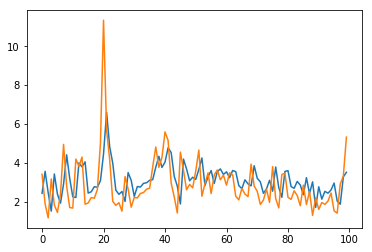

In [12]:
ema6_y_pred = ema6_model.predict([Volume_X_val[:-1],ema6_X_val[:-1]])
print(ema6_y_pred[1])
plt.plot(ema6_y_pred[1][:100])
plt.plot(ema6_Y_val[:100])
plt.show()
#print(np.sum(np.absolute(np.subtract(np.reshape(ema6_y_pred[1:],(ema6_y_pred.shape[0]-1,)),np.reshape(ema6_Y_val[:-1],(ema6_Y_val.shape[0]-1,)))))/(len(ema6_y_pred)-1))

Layer#2 ema12

In [ ]:
ema12_X_train = X_train_df.loc[:,2].values
ema12_Y_train = ema12_X_train[1:]
ema12_X_val = X_val_df.loc[:,2].values
ema12_Y_val = ema12_X_val[1:]
print(ema12_X_train)
ema12_units = 512
ema12_X_train = ema12_X_train.reshape(ema12_X_train.shape[0],1,1)
ema12_X_val = ema12_X_val.reshape(ema12_X_val.shape[0],1,1)
ema12_model = Sequential()
ema12_model.add(LSTM(ema12_units,input_shape=(1,1),activation='relu',kernel_initializer='lecun_uniform',kernel_regularizer=regularizers.l2(0.001),return_sequences=True))
#ema12_model.add(Dropout(0.01))
ema12_model.add(LSTM(ema12_units,kernel_regularizer=regularizers.l2(0.001)))
#ema12_model.add(Dropout(0.01))
ema12_model.add(Dense(1))
ema12_model.summary()
ema12_model.compile(loss='mean_squared_error',optimizer="Adam")
history = ema12_model.fit(ema12_X_train[:-1], ema12_Y_train, epochs=200, batch_size=32, shuffle=False,validation_data=(ema12_X_val[:-1],ema12_Y_val),callbacks=[early_stop])
ema12_y_pred = ema12_model.predict(ema12_X_val[:-1])
r2score = r2_score(ema12_Y_val,ema12_y_pred)
print("The R2 score on the Validation set is:\t{:0.3f}".format(r2score))

In [ ]:
macd_X_train = X_train_df.loc[:,2].values
macd_Y_train = macd_X_train[1:]
macd_X_val = X_val_df.loc[:,2].values
macd_Y_val = macd_X_val[1:]
print(macd_X_train)
macd_units = 512
macd_X_train = macd_X_train.reshape(macd_X_train.shape[0],1,1)
macd_X_val = macd_X_val.reshape(macd_X_val.shape[0],1,1)
macd_model = Sequential()
macd_model.add(LSTM(macd_units,input_shape=(1,1),activation='relu',kernel_initializer='lecun_uniform',kernel_regularizer=regularizers.l2(0.001),return_sequences=True))
#macd_model.add(Dropout(0.01))
macd_model.add(LSTM(macd_units,kernel_regularizer=regularizers.l2(0.001)))
#macd_model.add(Dropout(0.01))
macd_model.add(Dense(1))
macd_model.summary()
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
macd_model.compile(loss='mean_squared_error',optimizer="Adam")
history = macd_model.fit(macd_X_train[:-1], macd_Y_train, epochs=200, batch_size=32, shuffle=False,validation_data=(macd_X_val[:-1],macd_Y_val),callbacks=[early_stop])
macd_y_pred = macd_model.predict(macd_X_val[:-1])
r2score = r2_score(macd_Y_val,macd_y_pred)
print("The R2 score on the Validation set is:\t{:0.3f}".format(r2score))

In [ ]:
ema26_X_train = X_train_df.loc[:,2].values
ema26_Y_train = ema26_X_train[1:]
ema26_X_val = X_val_df.loc[:,2].values
ema26_Y_val = ema26_X_val[1:]
print(ema26_X_train)
ema26_units = 512
ema26_X_train = ema26_X_train.reshape(ema26_X_train.shape[0],1,1)
ema26_X_val = ema26_X_val.reshape(ema26_X_val.shape[0],1,1)
ema26_model = Sequential()
ema26_model.add(LSTM(ema26_units,input_shape=(1,1),activation='relu',kernel_initializer='lecun_uniform',kernel_regularizer=regularizers.l2(0.001),return_sequences=True))
#ema26_model.add(Dropout(0.01))
ema26_model.add(LSTM(ema26_units,kernel_regularizer=regularizers.l2(0.001)))
#ema26_model.add(Dropout(0.01))
ema26_model.add(Dense(1))
ema26_model.summary()
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
ema26_model.compile(loss='mean_squared_error',optimizer="Adam")
history = ema26_model.fit(ema26_X_train[:-1], ema26_Y_train, epochs=200, batch_size=32, shuffle=False,validation_data=(ema26_X_val[:-1],ema26_Y_val),callbacks=[early_stop])
ema26_y_pred = ema26_model.predict(ema26_X_val[:-1])
r2score = r2_score(ema26_Y_val,ema26_y_pred)
print("The R2 score on the Validation set is:\t{:0.3f}".format(r2score))

In [ ]:
wrsi6_X_train = X_train_df.loc[:,2].values
wrsi6_Y_train = wrsi6_X_train[1:]
wrsi6_X_val = X_val_df.loc[:,2].values
wrsi6_Y_val = wrsi6_X_val[1:]
print(wrsi6_X_train)
wrsi6_units = 512
wrsi6_X_train = wrsi6_X_train.reshape(wrsi6_X_train.shape[0],1,1)
wrsi6_X_val = wrsi6_X_val.reshape(wrsi6_X_val.shape[0],1,1)
wrsi6_model = Sequential()
wrsi6_model.add(LSTM(wrsi6_units,input_shape=(1,1),activation='relu',kernel_initializer='lecun_uniform',kernel_regularizer=regularizers.l2(0.001),return_sequences=True))
#wrsi6_model.add(Dropout(0.01))
wrsi6_model.add(LSTM(wrsi6_units,kernel_regularizer=regularizers.l2(0.001)))
#wrsi6_model.add(Dropout(0.01))
wrsi6_model.add(Dense(1))
wrsi6_model.summary()
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
wrsi6_model.compile(loss='mean_squared_error',optimizer="Adam")
history = wrsi6_model.fit(wrsi6_X_train[:-1], wrsi6_Y_train, epochs=200, batch_size=32, shuffle=False,validation_data=(wrsi6_X_val[:-1],wrsi6_Y_val),callbacks=[early_stop])
wrsi6_y_pred = wrsi6_model.predict(wrsi6_X_val[:-1])
r2score = r2_score(wrsi6_Y_val,wrsi6_y_pred)
print("The R2 score on the Validation set is:\t{:0.3f}".format(r2score))

In [ ]:
k9_X_train = X_train_df.loc[:,2].values
k9_Y_train = k9_X_train[1:]
k9_X_val = X_val_df.loc[:,2].values
k9_Y_val = k9_X_val[1:]
print(k9_X_train)
k9_units = 512
k9_X_train = k9_X_train.reshape(k9_X_train.shape[0],1,1)
k9_X_val = k9_X_val.reshape(k9_X_val.shape[0],1,1)
k9_model = Sequential()
k9_model.add(LSTM(k9_units,input_shape=(1,1),activation='relu',kernel_initializer='lecun_uniform',kernel_regularizer=regularizers.l2(0.001),return_sequences=True))
#k9_model.add(Dropout(0.01))
k9_model.add(LSTM(k9_units,kernel_regularizer=regularizers.l2(0.001)))
#k9_model.add(Dropout(0.01))
k9_model.add(Dense(1))
k9_model.summary()
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
k9_model.compile(loss='mean_squared_error',optimizer="Adam")
history = k9_model.fit(k9_X_train[:-1], k9_Y_train, epochs=200, batch_size=32, shuffle=False,validation_data=(k9_X_val[:-1],k9_Y_val),callbacks=[early_stop])
k9_y_pred = k9_model.predict(k9_X_val[:-1])
r2score = r2_score(k9_Y_val,k9_y_pred)
print("The R2 score on the Validation set is:\t{:0.3f}".format(r2score))

In [ ]:
d9_X_train = X_train_df.loc[:,2].values
d9_Y_train = d9_X_train[1:]
d9_X_val = X_val_df.loc[:,2].values
d9_Y_val = d9_X_val[1:]
print(d9_X_train)
d9_units = 512
d9_X_train = d9_X_train.reshape(d9_X_train.shape[0],1,1)
d9_X_val = d9_X_val.reshape(d9_X_val.shape[0],1,1)
d9_model = Sequential()
d9_model.add(LSTM(d9_units,input_shape=(1,1),activation='relu',kernel_initializer='lecun_uniform',kernel_regularizer=regularizers.l2(0.001),return_sequences=True))
#d9_model.add(Dropout(0.01))
d9_model.add(LSTM(d9_units,kernel_regularizer=regularizers.l2(0.001)))
#d9_model.add(Dropout(0.01))
d9_model.add(Dense(1))
d9_model.summary()
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
d9_model.compile(loss='mean_squared_error',optimizer="Adam")
history = d9_model.fit(d9_X_train[:-1], d9_Y_train, epochs=200, batch_size=32, shuffle=False,validation_data=(d9_X_val[:-1],d9_Y_val),callbacks=[early_stop])
d9_y_pred = d9_model.predict(d9_X_val[:-1])
r2score = r2_score(d9_Y_val,d9_y_pred)
print("The R2 score on the Validation set is:\t{:0.3f}".format(r2score))